In [1]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
from torch import load as torch_load
import seaborn as sns
import pandas as pd
from ipywidgets import widgets

ETM = torch_load('ETM_guardian_environment_cbow_10_parameters.pt')
theta = ETM['theta']
alpha = ETM['alpha']
rho = ETM['rho']
beta = ETM['beta']
vocab = ETM['vocab']
K = 5

In [2]:
# TSNE + SCATTERPLOT TOPIC AND WORDS

def tsne_visualize1(alpha,rho,beta,topwords=10):
    topics=alpha.shape[0]
    alpha_rho=np.vstack((alpha, rho))
    tsne_model = TSNE(n_components=2, verbose=0, random_state=0, angle=.99, init='pca')
    tsne_lda = tsne_model.fit_transform(alpha_rho)
    topK=np.argsort(-1 * beta, axis=1)[:,0:topwords]
    topKvect=np.concatenate(topK)
    indexes = list(range(topics))
    for i in list(topKvect):
        indexes.append(i)
    tsne_lda_topK=tsne_lda[indexes,]
    
    colours=list(range(topics))
    markers=list(np.repeat('D',topics))
    for i in range(topics):
        for j in range(topwords):
            colours.append(i)
            markers.append('.')
    
    colormap = []
    for name, hex in matplotlib.colors.cnames.items():
        colormap.append(hex)
    colormap = colormap[:tsne_lda_topK.shape[0]]
    colormap = list(np.array(colormap))
    colours2 = [colormap[c] for c in colours]
    
    fig = plt.figure()
    plt.figure(figsize = (16,8))
    plt.rcParams['font.size'] = '12'
    sns.set(style = 'darkgrid')
    plt.scatter(x=tsne_lda_topK[topics:, 0], y=tsne_lda_topK[topics:, 1], c=colours[topics:], marker='.', label='Words')
    plt.scatter(x=tsne_lda_topK[:topics, 0], y=tsne_lda_topK[:topics, 1], c=colours[:topics], marker='D', label='Topics')
    plt.title('TSNE dimensionality reduction', fontsize = 16)
    plt.legend(loc='best')
    #plt.xlim(-2, 2.5)
    #plt.ylim(-3, 3)
    plt.show()

<Figure size 432x288 with 0 Axes>

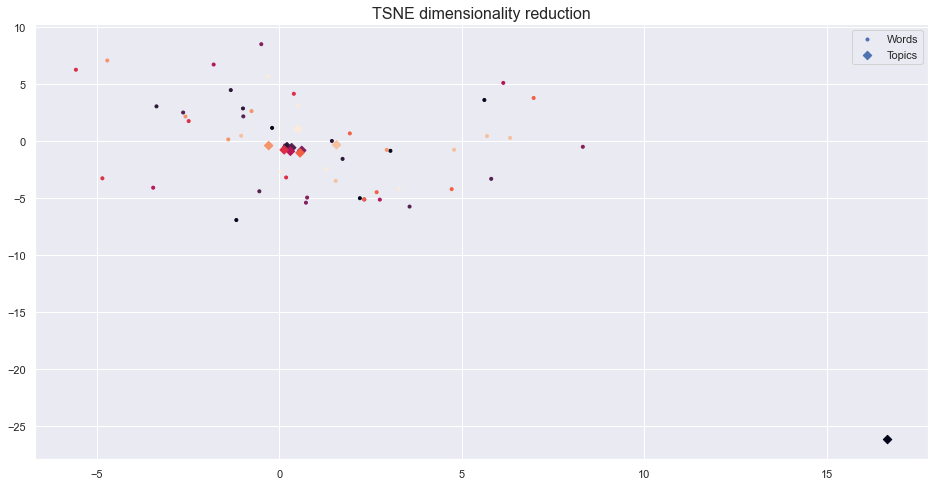

In [4]:
tsne_visualize1(alpha, rho, beta, topwords = 5)

In [48]:
# BARPLOT TOP WORDS PER TOPIC
#[str(i) for i in list((range(alpha.shape[0])))] 
def barplot_topwords(topic, beta, vocab, topwords=10):
    topK=np.argsort(-1 * beta[topic,])[0:topwords]
    data = {'word':[str(vocab[i]) for i in list(topK)],'beta':list(beta[topic,topK])}
    df = pd.DataFrame(data)
    
    fig, ax = plt.subplots(figsize = (9,5))
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(16)
        
    sns.barplot(x='beta', y='word', data = df, orient='h', edgecolor = 'black', color='steelblue')
    plt.title('Top ' + str(topwords) + ' words for topic ' + str(topic), fontsize = 18)
    plt.xlabel('Beta', fontsize = 18)
    plt.ylabel('Word', fontsize = 18)
    plt.show

In [49]:
from ipywidgets import interact, fixed

interact(barplot_topwords, topic = list((range(alpha.shape[0]))), beta = fixed(beta), vocab = fixed(vocab), topwords=list((10,15,20)))

interactive(children=(Dropdown(description='topic', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Dropdown…

<function __main__.barplot_topwords(topic, beta, vocab, topwords=10)>

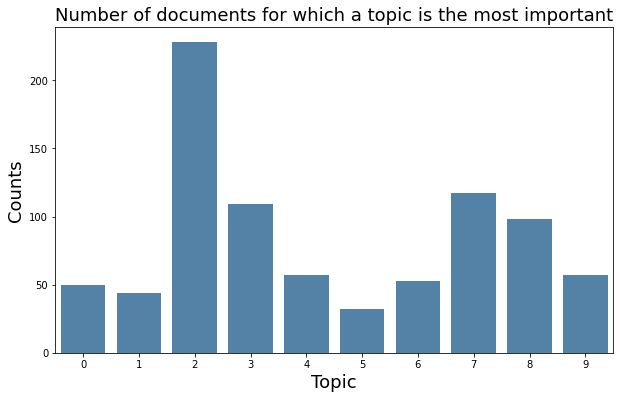

In [50]:
# BARPLOT NUM. DOCUMENTS IN WHICH A TOPIC IS THE MOST IMPORTANT

top_topics=list(np.argsort(-1 * theta, axis=1)[:,1])
count_top_topics=list()
for i in range(theta.shape[1]):
    count_top_topics.append((np.array(top_topics)==i).sum(axis=0))
data = {'topic':list(range(theta.shape[1])),'counts':count_top_topics}
df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(x='topic', y='counts', data = df, color='steelblue')
plt.title('Number of documents for which a topic is the most important', fontsize = 18)
plt.xlabel('Topic', fontsize = 18)
plt.ylabel('Counts', fontsize = 18)
plt.show()


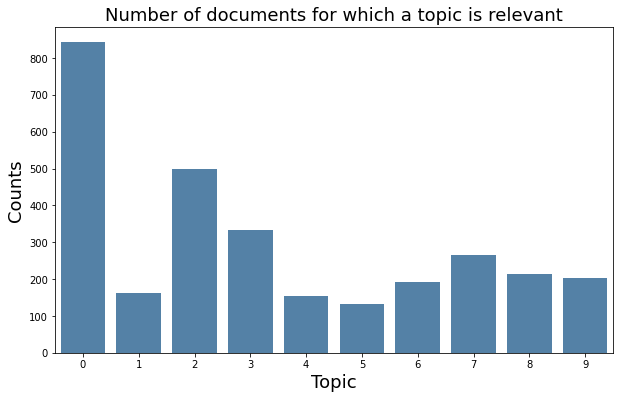

In [52]:
# BARPLOT NUM. DOCUMENTS IN WHICH A TOPIC IS DETECTED (Θ above a threshold)

theta_threshold=1/theta.shape[1]
topic_ndocs=(theta>theta_threshold).sum(axis=0)
data = {'topic':list(range(theta.shape[1])),'ndocs':list(topic_ndocs)}
df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(x='topic', y='ndocs', data = df, color = 'steelblue')
plt.title("Number of documents for which a topic is relevant", fontsize = 18)
plt.xlabel('Topic', fontsize = 18)
plt.ylabel('Counts', fontsize = 18)
plt.show()

In [55]:
# TOPIC DISTRIBUTION BY DOCUMENT

def get_doc_representation(theta, doc):
    data = {'topic':list(range(theta.shape[1])),'distrib':list(theta[doc,])}
    df = pd.DataFrame(data)
    fig, ax = plt.subplots(figsize = (10,6))
    sns.barplot(x='topic', y='distrib', data = df, color='steelblue')
    plt.title('Topic distribution in doc '+ str(doc), fontsize = 18)
    plt.xlabel('Topic', fontsize = 18)
    plt.ylabel('topic importance in doc '+ str(doc), fontsize = 18)
    plt.show()


In [62]:
interact(get_doc_representation, theta=fixed(theta), doc=widgets.IntSlider(min=0,max=theta.shape[0]-1,step=1,value=0))

interactive(children=(IntSlider(value=0, description='doc', max=844), Output()), _dom_classes=('widget-interac…

<function __main__.get_doc_representation(theta, doc)>

In [ ]:
# HISTOGRAM NUM. WORDS IN EACH DOCUMENT

#length_docs=np.random.poisson(lam=1000, size=theta.shape[0])
sns.histplot(length_docs).set(xlabel='num. words', ylabel='counts')
plt.axvline(np.mean(length_docs), linewidth=2.5, color='black')
plt.axvline(np.percentile(length_docs, 25), linestyle='--', color='black')
plt.axvline(np.percentile(length_docs, 50), linestyle='--', color='black')
plt.axvline(np.percentile(length_docs, 75), linestyle='--', color='black')
plt.legend('topright', labels=['mean', 'quartiles'])
plt.show()


In [ ]:
# METRICS PLOT TO COMPARE METHODS
# metrics = 2-dim array, rows: methods, columns: num topic
# method_labels = list of strings with names of the methods
# num_topic = list of integers, ex. [10,20,30,40,50]

def metrics_plot(metrics,method_labels,num_topic):
    for i in range(num_metrics):
        plt.plot(num_topic,metrics[i,], label=method_labels[i])
    plt.legend()
    plt.xticks(num_topic)
    plt.show()